# Image Smoothing
* Segmented images from ImageJ have noisy edges and leave behind uncharacteristic features, which could affect further processing.
* We should eliminate these features by smoothing the edges of the images.
* Procedure:
  * Start with a binary area mask of the segmented cell.
  * Use a mode filter to smooth out the edges.
  * Binary image - do edge detection. Edge detection appears to be bottleneck, introduces noise and extraneous features. 

In [1]:
# imports
import random

from PIL import Image, ImageFilter
from skimage.filters import sobel, laplace
import numpy as np
import matplotlib.pyplot as plt

import graphlearning as gl

In [3]:
immat_area_im = Image.open(r"C:\Users\Kyler\Desktop\UROP\Data\Cell Data\Immature_DC\immature-cell-1\immature-area.tif")
immat_area_array = np.array(immat_area_im)
mat_area_im = Image.open(r"C:\Users\Kyler\Desktop\UROP\Data\Cell Data\Mature_DC\mature-cell-1\mature-area.tif")
mat_area_array = np.array(mat_area_im)

## Smoothing and Edge Detection
Smooth image using a mode filter. The radius of the mode filter should be optimized to the desired degree of smoothing.

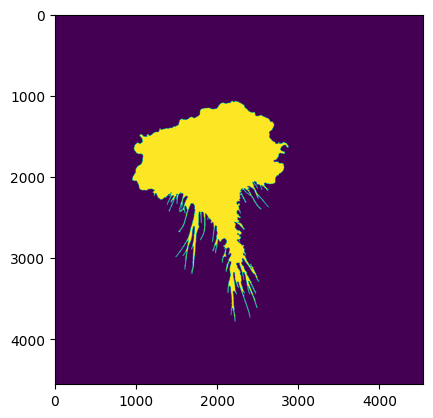

In [12]:
# Apply mode filter to the area mask
def smooth_image(image, kernel_size):
    im = image.filter(ImageFilter.ModeFilter(size=kernel_size))
    return np.array(im)

immat_smoothed = smooth_image(immat_area_im, 6)
plt.imshow(immat_smoothed)

In [5]:
# Use edge detection to get just the edges of the mask.
# Sobel/Laplace operators work best. Canny edge detection introduced more extraneous features. 
edges = sobel(immat_area_array)
immat_edges = (edges > 0).astype(np.uint8) * 255

edges = sobel(immat_smoothed)
immat_smoothed_edges = (edges > 0).astype(np.uint8) * 255

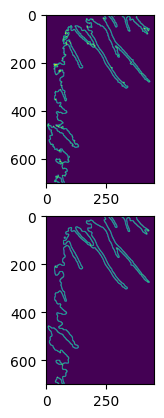

In [6]:
f, ax = plt.subplots(2)
ax[0].imshow(immat_edges[2100:2800, 2200:2650])
ax[1].imshow(immat_smoothed_edges[2100:2800, 2200:2650])

## Does smoothing change the eigenvalues of the Laplacian?
* Construct the graph using by sampling a point and its k-nearest neighbors from both the area and the boundary.
* Compute the graph Fourier transform and check if it changes significantly. 

### Sampling from Area

In [7]:
# Sample N points from the image array at random
def sample(im_array, N=5000): 
    u = im_array.nonzero()
    im_normal = (u[0] / im_array.shape[0], u[1] / im_array.shape[1])
    im_nonzero = np.array(list(map(list, zip(*im_normal)))) # nonzero points in the area
    y = im_nonzero[np.random.choice(im_nonzero.shape[0], N, replace=False), :]
    return y

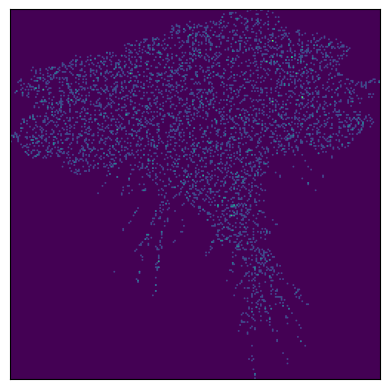

In [8]:
# We are getting good sampling from the interior
N = 5000
unsmoothed_area_sample = sample(immat_area_array) 
smoothed_area_sample = sample(immat_smoothed)
y = smoothed_area_sample[np.random.choice(smoothed_area_sample.shape[0], N, replace=False), :]
im, _, _ = np.histogram2d(y[:,0], y[:,1], bins=int(N/20))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
# Compute Graph Fourier Transform
def GFT(im_points, k=25, r=500):
    # im_points is sampled points from image, k is number of neighbors, r is number of eigenvalues
    W = gl.weightmatrix.knn(im_points, k)
    G = gl.graph(W)
    print("Graph is connected: ", G.isconnected())
    return G.eigen_decomp(k=r,normalization='normalized', method="lowrank")
    
unsmoothed_area_evals, _ = GFT(unsmoothed_area_sample)
smoothed_area_evals, _ = GFT(smoothed_area_sample)

Graph is connected:  True
Graph is connected:  True


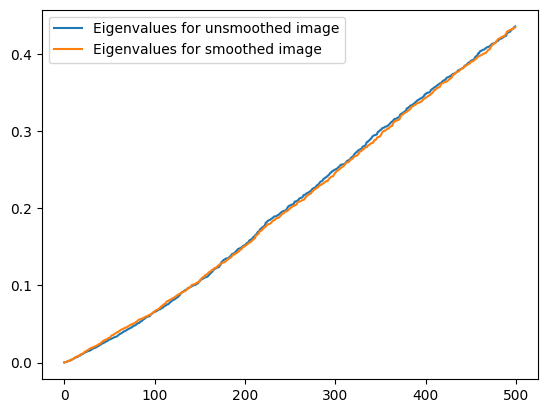

In [10]:
plt.plot(unsmoothed_area_evals,label='Eigenvalues for unsmoothed image')
plt.plot(smoothed_area_evals,label='Eigenvalues for smoothed image')
plt.legend()
plt.savefig('smoothing_area_eigenvalues.png')
plt.show()

### Sampling from Edges

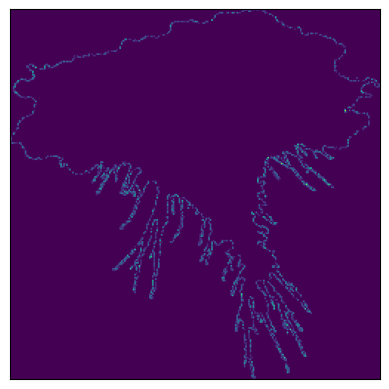

In [11]:
# We are getting good sampling from the interior
unsmoothed_edge_sample = sample(immat_edges) 
smoothed_edge_sample = sample(immat_smoothed_edges)
y = smoothed_edge_sample[np.random.choice(smoothed_edge_sample.shape[0], N, replace=False), :]
im, _, _ = np.histogram2d(y[:,0], y[:,1], bins=int(N/20))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

Graph is connected:  True
Graph is connected:  True


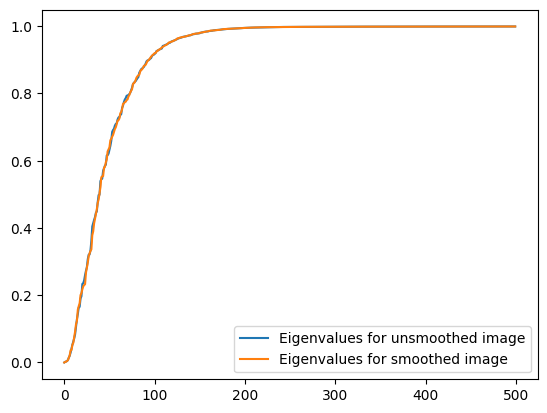

In [12]:
unsmoothed_edge_evals, _ = GFT(unsmoothed_edge_sample)
smoothed_edge_evals, _ = GFT(smoothed_edge_sample)
plt.plot(unsmoothed_edge_evals,label='Eigenvalues for unsmoothed image')
plt.plot(smoothed_edge_evals,label='Eigenvalues for smoothed image')
plt.legend()
plt.savefig('smoothing_edge_eigenvalues.png')
plt.show()

## Can Immature and Mature Dendritic Cells be Distinguished?
* Sampling from Interior or Exterior of Image

In [13]:
def GFT(im_points, k=25, r=500):
    # im_points is sampled points from image, k is number of neighbors, r is number of eigenvalues
    #eps = 0.05
    #W = gl.weightmatrix.epsilon_ball(np.array(im_points), eps)
    W = gl.weightmatrix.knn(im_points, k)
    G = gl.graph(W)
    print("Graph is connected: ", G.isconnected())
    return G.eigen_decomp(k=r,normalization='normalized', method="lowrank")

Graph is connected:  True
Graph is connected:  True


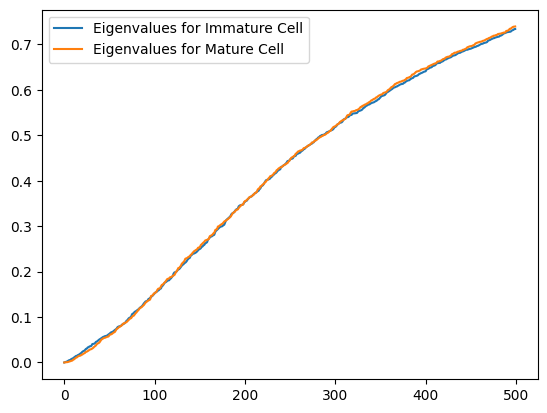

In [14]:
# Sampling from area
N = 2500
k = 25
smoothed_area_sample = sample(immat_smoothed, N=N)
smoothed_area_evals, _ = GFT(smoothed_area_sample)
mat_area_sample = sample(mat_smoothed, N=N)
mat_area_evals, _ = GFT(mat_area_sample)
plt.plot(smoothed_area_evals,label='Eigenvalues for Immature Cell')
plt.plot(mat_area_evals,label='Eigenvalues for Mature Cell')
plt.legend()
#plt.savefig('smoothing_edge_eigenvalues.png')
plt.show()

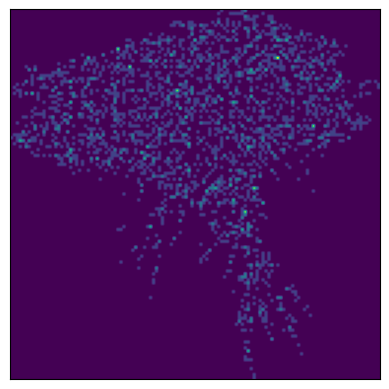

In [15]:
smoothed_area_sample = sample(immat_smoothed)
y = smoothed_area_sample[np.random.choice(smoothed_area_sample.shape[0], N, replace=False), :]
im, _, _ = np.histogram2d(y[:,0], y[:,1], bins=int(N/20))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

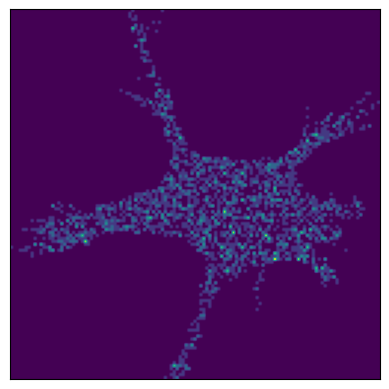

In [16]:
smoothed_area_sample = sample(mat_smoothed)
y = smoothed_area_sample[np.random.choice(smoothed_area_sample.shape[0], N, replace=False), :]
im, _, _ = np.histogram2d(y[:,0], y[:,1], bins=int(N/20))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

Graph is connected:  True
Graph is connected:  True


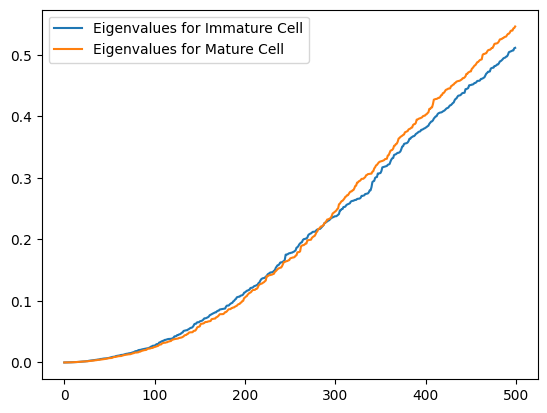

In [22]:
edges = sobel(immat_smoothed)
immat_smoothed_edges = (edges > 0).astype(np.uint8) * 255
edges = sobel(mat_smoothed)
mat_smoothed_edges = (edges > 0).astype(np.uint8) * 255

# Sampling from boundary
N = 5000
k = 25
smoothed_edge_sample = sample(immat_smoothed_edges, N=N)
smoothed_edge_evals, _ = GFT(smoothed_edge_sample, k=k)
mat_edge_sample = sample(mat_smoothed_edges, N=N)
mat_edge_evals, _ = GFT(mat_edge_sample, k=k)
plt.plot(smoothed_edge_evals,label='Eigenvalues for Immature Cell')
plt.plot(mat_edge_evals,label='Eigenvalues for Mature Cell')
plt.legend()
#plt.savefig('smoothing_edge_eigenvalues.png')
plt.show()

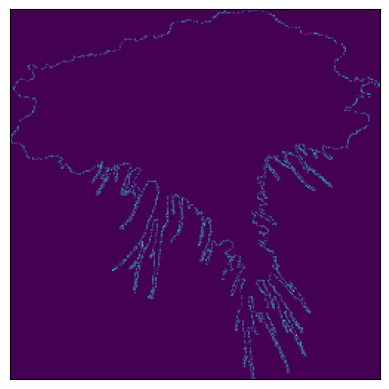

In [18]:
y = smoothed_edge_sample[np.random.choice(smoothed_edge_sample.shape[0], N, replace=False), :]
im, _, _ = np.histogram2d(y[:,0], y[:,1], bins=int(N/20))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

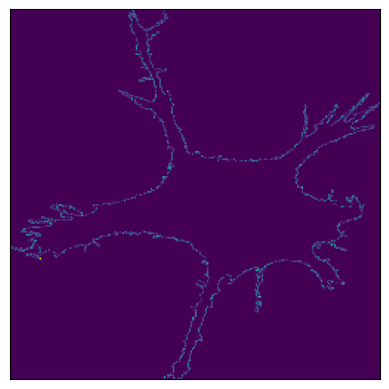

In [19]:
y = mat_edge_sample[np.random.choice(mat_edge_sample.shape[0], N, replace=False), :]
im, _, _ = np.histogram2d(y[:,0], y[:,1], bins=int(N/20))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

([], [])

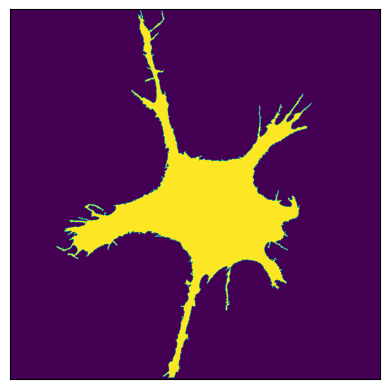

In [20]:
plt.imshow(mat_smoothed)
plt.xticks([])
plt.yticks([])

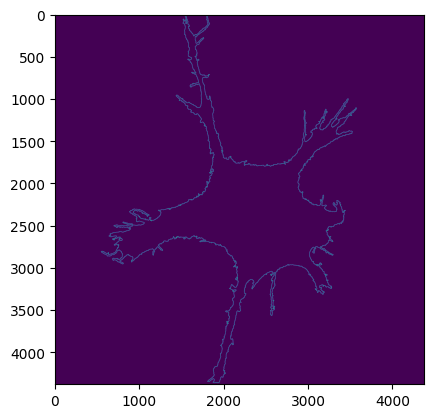

In [21]:
plt.imshow(mat_smoothed_edges)